# Neural machine translation

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/

In [ ]:
#!wget http://www.manythings.org/anki/rus-eng.zip

In [ ]:
#!mkdir rus-eng
#!unzip rus-eng.zip -d rus-eng/

In [ ]:
#!ls /content/rus-eng/ -lah

In [ ]:
# Download the file
path_to_file = "./content/rus-eng/rus.txt"

In [ ]:
def preprocess_sentence(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [ ]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [ ]:
en, ru = create_dataset(path_to_file, None)
print(en[-1])
print(ru[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с уч том миллионов живущих на земле людей , ни один подходящи

In [ ]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)


In [ ]:
len(en), len(ru)

(429117, 429117)

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [ ]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
161 ----> время
14 ----> у
17 ----> меня
32 ----> есть
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
24 ----> have
125 ----> time
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=False,
                                       return_state=False,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        state = self.gru(x, initial_state = hidden)
        return state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_hidden = encoder(example_input_batch, sample_hidden)
# print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        # self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden):
        # enc_output shape == (batch_size, max_length, hidden_size)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x, initial_state=hidden)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden)



In [ ]:
decoder_sample_h.shape

TensorShape([64, 1024])

## Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))

        variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
EPOCHS = 50
loss_info_to_plot=[]

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
            
            loss_info_to_plot.append(batch_loss.numpy())
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6195
Epoch 1 Batch 100 Loss 1.9620
Epoch 1 Batch 200 Loss 1.8121
Epoch 1 Batch 300 Loss 1.7051
Epoch 1 Batch 400 Loss 1.6295
Epoch 1 Batch 500 Loss 1.5172
Epoch 1 Batch 600 Loss 1.4993
Epoch 1 Batch 700 Loss 1.2375
Epoch 1 Batch 800 Loss 1.1137
Epoch 1 Batch 900 Loss 1.0774
Epoch 1 Batch 1000 Loss 1.0285
Epoch 1 Batch 1100 Loss 0.9228
Epoch 1 Batch 1200 Loss 0.9938
Epoch 1 Loss 1.4439
Time taken for 1 epoch 99.18611359596252 sec

Epoch 2 Batch 0 Loss 0.8079
Epoch 2 Batch 100 Loss 0.8847
Epoch 2 Batch 200 Loss 0.8949
Epoch 2 Batch 300 Loss 0.7438
Epoch 2 Batch 400 Loss 0.7852
Epoch 2 Batch 500 Loss 0.7611
Epoch 2 Batch 600 Loss 0.7419
Epoch 2 Batch 700 Loss 0.6991
Epoch 2 Batch 800 Loss 0.7266
Epoch 2 Batch 900 Loss 0.8408
Epoch 2 Batch 1000 Loss 0.6807
Epoch 2 Batch 1100 Loss 0.6675
Epoch 2 Batch 1200 Loss 0.6382
Epoch 2 Loss 0.7369
Time taken for 1 epoch 91.10360097885132 sec

Epoch 3 Batch 0 Loss 0.3818
Epoch 3 Batch 100 Loss 0.4381
Epoch 3 Batch 200 Loss 0.467

Epoch 18 Batch 1100 Loss 0.1049
Epoch 18 Batch 1200 Loss 0.0755
Epoch 18 Loss 0.0653
Time taken for 1 epoch 88.7690806388855 sec

Epoch 19 Batch 0 Loss 0.0326
Epoch 19 Batch 100 Loss 0.0486
Epoch 19 Batch 200 Loss 0.0578
Epoch 19 Batch 300 Loss 0.0394
Epoch 19 Batch 400 Loss 0.0466
Epoch 19 Batch 500 Loss 0.0672
Epoch 19 Batch 600 Loss 0.0531
Epoch 19 Batch 700 Loss 0.1089
Epoch 19 Batch 800 Loss 0.0627
Epoch 19 Batch 900 Loss 0.0641
Epoch 19 Batch 1000 Loss 0.0514
Epoch 19 Batch 1100 Loss 0.0385
Epoch 19 Batch 1200 Loss 0.0588
Epoch 19 Loss 0.0632
Time taken for 1 epoch 84.92843723297119 sec

Epoch 20 Batch 0 Loss 0.0211
Epoch 20 Batch 100 Loss 0.0504
Epoch 20 Batch 200 Loss 0.0436
Epoch 20 Batch 300 Loss 0.0444
Epoch 20 Batch 400 Loss 0.0599
Epoch 20 Batch 500 Loss 0.0705
Epoch 20 Batch 600 Loss 0.0690
Epoch 20 Batch 700 Loss 0.0675
Epoch 20 Batch 800 Loss 0.0729
Epoch 20 Batch 900 Loss 0.0561
Epoch 20 Batch 1000 Loss 0.0638
Epoch 20 Batch 1100 Loss 0.0801
Epoch 20 Batch 1200 Loss 0.

Epoch 36 Batch 200 Loss 0.0383
Epoch 36 Batch 300 Loss 0.0827
Epoch 36 Batch 400 Loss 0.0306
Epoch 36 Batch 500 Loss 0.0312
Epoch 36 Batch 600 Loss 0.0664
Epoch 36 Batch 700 Loss 0.0600
Epoch 36 Batch 800 Loss 0.0731
Epoch 36 Batch 900 Loss 0.0726
Epoch 36 Batch 1000 Loss 0.0827
Epoch 36 Batch 1100 Loss 0.0750
Epoch 36 Batch 1200 Loss 0.0945
Epoch 36 Loss 0.0516
Time taken for 1 epoch 88.13980269432068 sec

Epoch 37 Batch 0 Loss 0.0407
Epoch 37 Batch 100 Loss 0.0426
Epoch 37 Batch 200 Loss 0.0428
Epoch 37 Batch 300 Loss 0.0588
Epoch 37 Batch 400 Loss 0.0598
Epoch 37 Batch 500 Loss 0.0612
Epoch 37 Batch 600 Loss 0.0279
Epoch 37 Batch 700 Loss 0.0390
Epoch 37 Batch 800 Loss 0.0297
Epoch 37 Batch 900 Loss 0.0519
Epoch 37 Batch 1000 Loss 0.0322
Epoch 37 Batch 1100 Loss 0.0813
Epoch 37 Batch 1200 Loss 0.1049
Epoch 37 Loss 0.0512
Time taken for 1 epoch 84.84851145744324 sec

Epoch 38 Batch 0 Loss 0.0232
Epoch 38 Batch 100 Loss 0.0418
Epoch 38 Batch 200 Loss 0.0482
Epoch 38 Batch 300 Loss 0.0

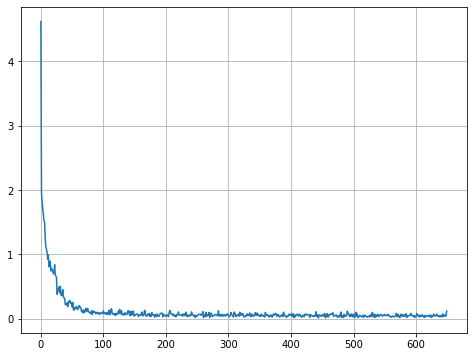

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(loss_info_to_plot)
plt.grid(True)
plt.show()

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden = decoder(dec_input, dec_hidden)

        # storing the attention weights to plot later on
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [ ]:
def translate(sentence):
    result, sentence = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

## Restore the latest checkpoint and test

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
translate('Здесь хорошо.')

Input: <start> здесь хорошо . <end>
Predicted translation: it's good here . <end> 


In [ ]:
translate('Я не смогу поехать.')

Input: <start> я не смогу поехать . <end>
Predicted translation: i can't go . <end> 


In [ ]:
translate(u'Вы еще дома?')

Input: <start> вы еще дома ? <end>
Predicted translation: are you home yet ? <end> 


In [ ]:
translate(u'Вы все еще дома?')

Input: <start> вы все еще дома ? <end>
Predicted translation: are you still at home ? <end> 


In [ ]:
translate(u'Попробуй сделать это.')

Input: <start> попробуй сделать это . <end>
Predicted translation: try and do it . <end> 


In [ ]:
translate(u'Я люблю, когда идет снег.')

Input: <start> я люблю , когда идет снег . <end>
Predicted translation: i think we'll snow today . <end> 


In [ ]:
translate(u'Я никогда такого не делаю.')

Input: <start> я никогда такого не делаю . <end>
Predicted translation: i never do that . <end> 


In [ ]:
#tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)